In [105]:
import requests
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from time import sleep
# Objective website
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
headers = {'User-Agent': user_agent}
URL = 'https://www.cervezasonline.com/'
session = requests.Session()

In [106]:
#First we want to check the robots.txt file of our objective website
#A function get_robot_txt is constructed to check any url
def get_robot_txt(url):
    if url.endswith('/'):
        path = url
    else:
        path = url + '/'
    req = requests.get(path + "robots.txt",data =None)
    return req.text
# Read robots.txt file
# No product pages within any Disallow
print(get_robot_txt(URL))

# robots.txt automaticaly generated by PrestaShop e-commerce open-source solution
# http://www.prestashop.com - http://www.prestashop.com/forums
# This file is to prevent the crawling and indexing of certain parts
# of your site by web crawlers and spiders run by sites like Yahoo!
# and Google. By telling these "robots" where not to go on your site,
# you save bandwidth and server resources.
# For more information about the robots.txt standard, see:
# http://www.robotstxt.org/robotstxt.html
User-agent: *
# Allow Directives
Allow: */modules/*.css
Allow: */modules/*.js
# Private pages
Disallow: /*?orderby=
Disallow: /*?orderway=
Disallow: /*?tag=
Disallow: /*?id_currency=
Disallow: /*?search_query=
Disallow: /*?back=
Disallow: /*?n=
Disallow: /*&orderby=
Disallow: /*&orderway=
Disallow: /*&tag=
Disallow: /*&id_currency=
Disallow: /*&search_query=
Disallow: /*&back=
Disallow: /*&n=
Disallow: /*controller=addresses
Disallow: /*controller=address
Disallow: /*controller=authentication
Disall

In [107]:
# Class Category. All of the identified categories have one of these
class Category:
  def __init__(self, category_url=None):
    if category_url[-1] == '#': self.url = category_url[:-1]
    else: self.url = category_url    

  # Identify if there is a 'Show All' option
  def get_all_products_web_page(self):
    soup = BeautifulSoup(session.get(self.url, headers=headers).content, 'html.parser')
    try: 
      # Identify number of All products in "Mostrar Todos" button
      value = soup.find(id='pagination').find(id='nb_item')['value']
      # Create new URL with the new parametres of number of producst as n
      self.url = self.url+'?n='+value
    except: pass

  # Identify all the products in a category page
  def get_all_product_links(self):
    # Get page with all products from category
    self.get_all_products_web_page()
    soup = BeautifulSoup(session.get(self.url, headers=headers).content, 'html.parser')
    # Get all product links one by one from html code
    product_links = [product['href'] for product in soup.findAll('a', class_='product_img_link')]
    print("Category URL: ", self.url)
    print("Number of products in category: ", len(product_links))
    return(product_links)

In [108]:
# This method returns all producst identified in the website
def get_all_products(url):
  # Identify all categories on the top block div
  soup = BeautifulSoup(session.get(url, headers=headers).content, 'html.parser')
  # Get all identified categories
  # Detele all categories that are longer than one subdomain
  categories = ['/'.join((url + category['href'][1:]).split('/')[0:4]) for category in soup.find(id='block_top_menu').find_all('a') if category['href']!='#' and category['href'][0]=='/']
  # Create categories with only unqiue urls
  categories = [Category(category) for category in list(set(categories))]
  # Get all the links to products per cateogry
  products = []
  [products.extend(category.get_all_product_links()) for category in categories]
  # Get only unique URLs
  products = list(set(products))
  print("Total number of products: ", len(products))
  return(products)

# Call function get_all_products() to get all products from 'https://www.cervezasonline.com/' website
# Parse all of the products in the website


In [149]:

def substring_after(s, delim):
    return s.partition(delim)[2]

# This function returns a pandas dataframe containing 9 fiedls: Beer category, beer name, beer size, beer type, beer color,
# beer graduation, beer price and beer unitary price for a list of URLs from 'https://www.cervezasonline.com/' website.

def process_cervezasonline_data(URL):
    df = pd.DataFrame()
    for url in URL:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        results = soup.find(id='product')

        product_name = results.find('div', class_='product_desc')
        product_desc = results.find('div', class_='product_desc')
        
        try:
            product_price = soup.find('p', class_='our_price_display').text
        except AttributeError:
            product_price = 'NA'
        
        try:
            unit_price = soup.find('p', class_='unit-price').text
        except AttributeError:
            unit_price = 'NA'
        
        l = []
        l.append([
        # Get beer category DF field    
        substring_after(url,"https://www.cervezasonline.com/").split('/', 1)[0].strip().upper(), 
        
        # Get beer name DF field
        product_name.text.strip().split('Origen', 1)[0].replace(product_name.text.strip().
                                                                split('Origen', 1)[0][product_name.text.strip().
                                                                split('Origen', 1)[0].rindex(' ')+1:],"").strip(),
        
        # Get beer size DF field
        product_name.text.strip().split('Origen', 1)[0][product_name.text.strip().split('Origen', 1)[0].
                                                                  rindex(' ')+1:].upper().replace(",",".").strip(),
        
        # Get beer origin DF field
        substring_after(product_desc.text.strip(),"Origen:").
        replace(substring_after(product_desc.text.strip(),"Tipo:"),"").replace("Tipo:","").strip(),
        
        # Get beer type DF field
        substring_after(product_desc.text.strip(),"Tipo:").
        replace(substring_after(product_desc.text.strip(),"Color:"),"").replace("Color:","").strip(),
        
        # Get beer color DF field          
        substring_after(product_desc.text.strip(),"Color:").
        replace(substring_after(product_desc.text.strip(),"Graduación:"),"").replace("Graduación:","").strip(),
        
        # Get beer graduation DF field 
        substring_after(product_desc.text.strip(),"Graduación:"),
        
        # Get beer price DF field 
        product_price.replace(",",".").replace(" ","").split('€', 1)[0].strip(),

        # Get beer unitary price DF field 
        unit_price.replace(",",".").replace(" ","").split('€', 1)[0].strip()
             
             ])

        # We append to a pandas dataframe new data for each URL. Also we add DF colum names and reset the index
        df = df.append(pd.DataFrame(l,columns = ['Categoria','Nombre de la Cerveza', 'Tamaño','Origen','Tipo','Color',
                                             'Graduación','Precio en €','Precio por Litro en €'])).reset_index(drop=True)

    return(df)
    


In [151]:
URL = []
df = process_cervezasonline_data(get_all_products('https://www.cervezasonline.com/'))

Category URL:  https://www.cervezasonline.com/304-latas
Number of products in category:  19
Category URL:  https://www.cervezasonline.com/312-estuche?n=57
Number of products in category:  57
Category URL:  https://www.cervezasonline.com/340-estuche-madera
Number of products in category:  7
Category URL:  https://www.cervezasonline.com/309-botellones?n=160
Number of products in category:  160
Category URL:  https://www.cervezasonline.com/302-botella-cerveza?n=523
Number of products in category:  523
Category URL:  https://www.cervezasonline.com/379-selecciones
Number of products in category:  1
Category URL:  https://www.cervezasonline.com/299-cristaleria?n=210
Number of products in category:  210
Category URL:  https://www.cervezasonline.com/354-barriles
Number of products in category:  2
Category URL:  https://www.cervezasonline.com/380-seleccion-de-verano
Number of products in category:  22
Category URL:  https://www.cervezasonline.com/341-botellon-metal
Number of products in categor

En este punto hemos conseguido un dataframe de pandas con todos los productos de la web y los campos que necesitamos. Vamos a explorar el dataframe y eliminar los registros que no nos son útiles para el análisis. 

In [180]:
df.head(10)

,Categoria,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €
0,BOTELLA-CERVEZA,Fruli Strawberry 33Cl,,Bélgica,Trigo afrutada,Rojo fresa turbio,4.1º,1.95,7.15
1,BOTELLA-CERVEZA,Hoegaarden Rosee 25Cl,,Bélgica,Trigo afrutada,Rosado oscuro,4.5º,1.85,8.95
2,BOTELLA-CERVEZA,Zeta SuperHell,33CL,España,Artesanal,Dorado,"5,5º",2.50,7.57
3,ESTUCHE-MADERA,Estuche Kwak Madera 4*33Cl + 1 Vaso,DUO,,,,,34.95,NA
4,BOTELLA-CERVEZA,Bonsecours Blonde 33Cl,,Bélgica,Ale,Rubia,8º,3.40,12.46
5,BOTELLA-CERVEZA,Floris Frambuesa 33Cl,,Bélgica,Trigo aromatizada,Rojo vino,3.6º,2.15,7.89
6,BOTELLA-CERVEZA,Queue Charrue Brune 33Cl,,Bélgica,Especial,Marrón,5.4º,3.30,12.11
7,BOTELLA-CERVEZA,Clausthaler Lemon 33Cl,,Alemania,Sin alcohol,Rubia,0.17º,0.85,3.12
8,BOTELLONES,Biere Des Ours 75Cl,,Bélgica,Ale,Ámbar,8.5º,4.80,7.74
9,BOTELLA-CERVEZA,Innis And Gunn Rum Finish 33Cl,,Escocia,Artesanal,Rojo intenso,5.6º,1.85,6.78


In [302]:
data = df
data.groupby('Categoria').count()

,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €,Color Simplificado
Categoria,,,,,,,,,
BOTELLA,1,1,1,1,1,1,1,1,1
BOTELLA-CERVEZA,522,522,522,522,522,522,520,522,507
BOTELLON-METAL,11,11,11,11,11,11,11,11,4
BOTELLONES,160,160,160,160,160,160,160,160,154
CRISTALERIA,210,210,210,210,210,210,210,210,0
ESTUCHE,57,57,57,57,57,57,57,57,0
ESTUCHE-MADERA,7,7,7,7,7,7,7,7,0
KEY-KEG,1,1,1,1,1,1,1,1,1
LATAS,19,19,19,19,19,19,19,19,17


In [303]:
#Eliminamos el registro con categoria 'INICIO' porque no tiene valor y sustituimos los campos NA por NaN
data.drop( data[ data['Categoria'] == 'INICIO' ].index , inplace=True)
data = data.replace("NA", np.NaN)


In [304]:
#Vamos a ver que categorias no tienen precios unitarios

data[data['Precio por Litro en €'].isna()].groupby('Categoria').count()


,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €,Color Simplificado
Categoria,,,,,,,,,
BOTELLA-CERVEZA,11,11,11,11,11,11,9,0,0
BOTELLONES,1,1,1,1,1,1,1,0,0
CRISTALERIA,210,210,210,210,210,210,210,0,0
ESTUCHE,57,57,57,57,57,57,57,0,0
ESTUCHE-MADERA,7,7,7,7,7,7,7,0,0
LATAS,2,2,2,2,2,2,2,0,0


Vamos a eliminar todos los registros del dataframe con campos NaN ya que no nos interesan para el analisis posterior. Como vemos son la mayoria cristaleria y estuches de regalo.

In [305]:
data = data.dropna()
data.describe()

,Categoria,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €,Color Simplificado
count,684,684,684,684,684,684,684,684,684,684
unique,6,684,12,35,64,198,126,182,276,41
top,BOTELLA-CERVEZA,Caracole 33Cl,,Bélgica,Ale,Rubia,8º,2.00,8.06,Rubia
freq,507,1,596,447,182,69,39,28,21,102


In [330]:
#Vamos a crear una nueva columna para el color sólo con la primera palabra y en femenino, para generar menos categorias.
data['Color Simplificado'] = data['Color'].str.split().str.get(0)
data.loc[data['Color Simplificado'].str[-1] == "o", 'Color Simplificado'] = data['Color Simplificado'].str[:-1] + 'a'
data.groupby('Color Simplificado').count().reset_index().sort_values("Categoria",ascending=False)


,Color Simplificado,Categoria,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €
28,Rubia,192,192,192,192,192,192,192,192,192
32,Ámbar,97,97,97,97,97,97,97,97,97
10,Dorada,95,95,95,95,95,95,95,95,95
22,Oscura,59,59,59,59,59,59,59,59,59
14,Marrón,54,54,54,54,54,54,54,54,54
25,Roja,45,45,45,45,45,45,45,45,45
0,Amarilla,31,31,31,31,31,31,31,31,31
9,Cobriza,13,13,13,13,13,13,13,13,13
19,Negra,11,11,11,11,11,11,11,11,11
26,Rojiza,9,9,9,9,9,9,9,9,9


In [319]:
import plotly.graph_objects as go
from collections import Counter

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=data['Nombre de la Cerveza'], x=data['Origen'], name="COUNT")).update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Número de cervezas por origen"
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=data['Nombre de la Cerveza'], x=data['Tipo'], name="COUNT")).update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Número de cervezas por tipo"
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=df['Precio por Litro en €'], x=df['Precio por Litro en €'], name="COUNT")).update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Precio por Litro en €"
)
fig.show()

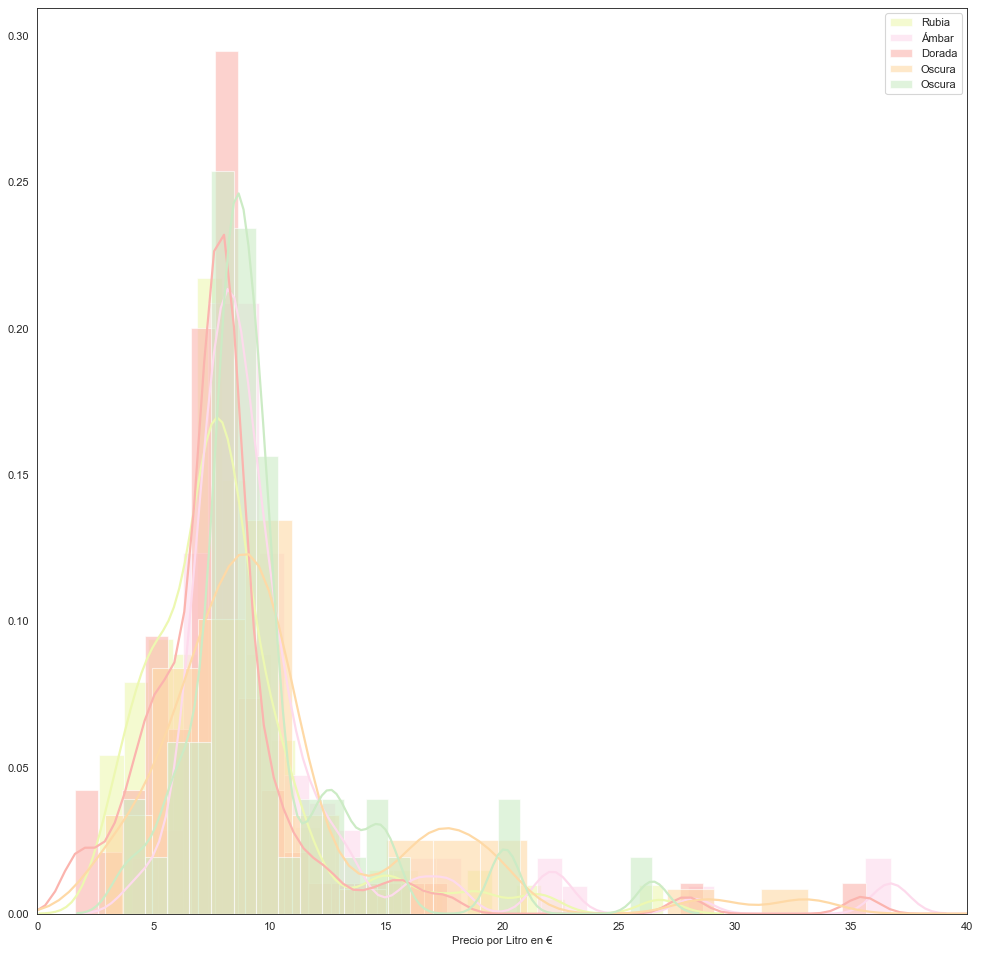

In [347]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")

x1 = data.loc[data['Color Simplificado']=='Rubia','Precio por Litro en €']
x2 = data.loc[data['Color Simplificado']=='Ámbar','Precio por Litro en €']
x3 = data.loc[data['Color Simplificado']=='Dorada','Precio por Litro en €']
x4 = data.loc[data['Color Simplificado']=='Oscura','Precio por Litro en €']
x5 = data.loc[data['Color Simplificado']=='Marrón','Precio por Litro en €']


# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(15,15), dpi= 80)
sns.distplot(x1, color="#edf8b1", label="Rubia", **kwargs)
sns.distplot(x2, color="#fddaec", label="Ámbar", **kwargs)
sns.distplot(x3, color="#fbb4ae", label="Dorada", **kwargs)
sns.distplot(x4, color="#fed9a6", label="Oscura", **kwargs)
sns.distplot(x5, color="#ccebc5", label="Oscura", **kwargs)

plt.xlim(0,40)
plt.legend();

In [349]:
df.to_csv(r'C:\Users\guillermo.arguello\Documents\Master Data Science UOC\Tipología y ciclo de vida de los datos\Pec1 2020\pec_1_web_scrapping.csv')
